# Shopify Winter 2019 Data Science Internship Challenge

### Sudarshan Bangalore

#### September 14, 2018

This file was created in Jupyter notebook and uses Python and SQL for Shopify's Winter 2019 Data Science Intern Challenge.

<hr>

## Summary

Outliers are influencing the dataset due to the use of a non-robust metric, mean. These outliers include wholesale orders and sneakers with very high prices. Assuming that we want a more reasonable idea of the average size of orders, we have two options.

 1. Remove outliers, including wholesale purchases and unreasonable large per unit costs. This results in an AOV of <b>\$302</b>. This would be the best option if we are concerned about accuracy and are looking to find the mean without outliers such as fraud or business purchases.
 
 
 2. Use a robust statistic such as median rather than mean. This results in an AOV of <b>\$284</b>. This method retains 93.8% accuracy (284/302), while being significantly simpler to implement. This would  involve lower computing and time costs and maintains relevance even if other issue are introduced compared to  the alternative as it is robust to outliers unlike mean.
 
 
<i>Shop 78 and user 607 should both be investigated after this analysis for any inconsistencies with internal data.</i>
 
If instead, we have another objective - not to find a representative average size - but rather, to find if fraud exists or to count for wholesale orders as well, we would need to find a different approach.

<hr>

### Analysis

The objective is to identify a better AOV as $3,145.13 seems to be too high. This program will identify why the AOV is significantly higher than anticipated, and alternative solutions to rectify this. It will focus on order_amount as that is the relevant metric.

In [1]:
#Loading the data and libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from scipy import stats
import math

pd.options.display.float_format = '{:,.2f}'.format
order_data = pd.read_csv("~/Dropbox/Shopify/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")

In [2]:
#Let's take a glance at the data structure:
order_data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,692,78,878,154350,6,debit,3/27/2017 22:51
1,2493,78,834,102900,4,debit,3/4/2017 4:37
2,1260,78,775,77175,3,credit_card,3/27/2017 9:27
3,2565,78,915,77175,3,debit,3/25/2017 1:19
4,2691,78,962,77175,3,debit,3/22/2017 7:33


In [22]:
order_data.describe()

,order_id,shop_id,user_id,order_amount,total_items,avg_cost
count,"5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00"
mean,"2,500.50",50.08,849.09,"3,145.13",8.79,387.74
std,"1,443.52",29.01,87.80,"41,282.54",116.32,"2,441.96"
min,1.00,1.00,607.00,90.00,1.00,90.00
25%,"1,250.75",24.00,775.00,163.00,1.00,133.00
50%,"2,500.50",50.00,849.00,284.00,2.00,153.00
75%,"3,750.25",75.00,925.00,390.00,3.00,169.00
max,"5,000.00",100.00,999.00,"704,000.00","2,000.00","25,725.00"


Note that the order amount median is \$284, the mean is \$3,145, and the largest order is \$704,000. This means the data has outliers. Let's take a look at the distribution to confirm this.

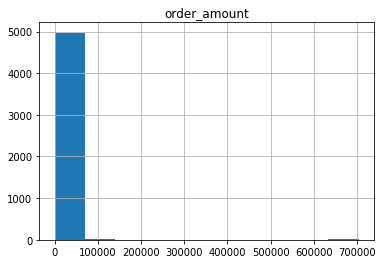

In [4]:
order_data.hist(column='order_amount');

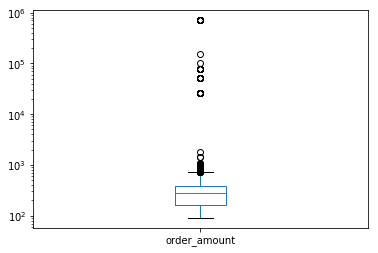

In [5]:
order_data.order_amount.plot(kind='box', logy='true')

We know that there are outliers. Let's take the top 20 orders by order size and see if there's a trend.

In [6]:
order_data.nlargest(20,'order_amount')

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
46,16,42,607,704000,2000,credit_card,3/7/2017 4:00
47,61,42,607,704000,2000,credit_card,3/4/2017 4:00
48,521,42,607,704000,2000,credit_card,3/2/2017 4:00
49,1105,42,607,704000,2000,credit_card,3/24/2017 4:00
50,1363,42,607,704000,2000,credit_card,3/15/2017 4:00
51,1437,42,607,704000,2000,credit_card,3/11/2017 4:00
52,1563,42,607,704000,2000,credit_card,3/19/2017 4:00
53,1603,42,607,704000,2000,credit_card,3/17/2017 4:00
54,2154,42,607,704000,2000,credit_card,3/12/2017 4:00
55,2298,42,607,704000,2000,credit_card,3/7/2017 4:00


We notice that the top 17 orders are all done by user_id 607 with a credit card at the exact same time: 4:00 AM, some on the same day, at the same shop. They could potentially be wholesale orders, fraud, or a system error.

We also notice that the orders directly below are suspect, billing very large amounts for a small number of items. This could once again be fraud, a system error, or potentially in an unlikely circumstance, VERY expensive shoes.

Let's note the first problem, and table it for later correction. Let's now look at the second problem by creating an average cost per shoe column.

In [7]:
order_data['avg_cost'] = order_data.order_amount/order_data.total_items

In [8]:
order_data.head(5)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,avg_cost
0,692,78,878,154350,6,debit,3/27/2017 22:51,"25,725.00"
1,2493,78,834,102900,4,debit,3/4/2017 4:37,"25,725.00"
2,1260,78,775,77175,3,credit_card,3/27/2017 9:27,"25,725.00"
3,2565,78,915,77175,3,debit,3/25/2017 1:19,"25,725.00"
4,2691,78,962,77175,3,debit,3/22/2017 7:33,"25,725.00"


In [10]:
order_data.avg_cost.describe()

count    5,000.00
mean       387.74
std      2,441.96
min         90.00
25%        133.00
50%        153.00
75%        169.00
max     25,725.00
Name: avg_cost, dtype: float64

The same issue as order size is seen in the average cost per shoe. While the median is \$153, the mean is \$387, and the largest is \$25,725!

Once again, let's take the top 50 orders by average cost per item and see if there's a trend.

In [14]:
order_data.nlargest(50,'avg_cost')

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,avg_cost
0,692,78,878,154350,6,debit,3/27/2017 22:51,"25,725.00"
1,2493,78,834,102900,4,debit,3/4/2017 4:37,"25,725.00"
2,1260,78,775,77175,3,credit_card,3/27/2017 9:27,"25,725.00"
3,2565,78,915,77175,3,debit,3/25/2017 1:19,"25,725.00"
4,2691,78,962,77175,3,debit,3/22/2017 7:33,"25,725.00"
5,2907,78,817,77175,3,debit,3/16/2017 3:45,"25,725.00"
6,3404,78,928,77175,3,debit,3/16/2017 9:45,"25,725.00"
7,3725,78,766,77175,3,credit_card,3/16/2017 14:13,"25,725.00"
8,4193,78,787,77175,3,credit_card,3/18/2017 9:25,"25,725.00"
9,4421,78,969,77175,3,debit,3/9/2017 15:21,"25,725.00"


We see that shop id 78 had 46 transactions priced at \$25,725 which impacts the mean.

Calculating the AOV after removing shop 78 and user 607 provides us with a cleaner AOV of 302.58. We can see this represented in the cleaner graphs as well. 

In [21]:
order_data_clean = order_data[order_data.shop_id != 78]
order_data_clean = order_data_clean[order_data_clean.user_id != 607]
order_data_clean.describe()

,order_id,shop_id,user_id,order_amount,total_items,avg_cost
count,"4,937.00","4,937.00","4,937.00","4,937.00","4,937.00","4,937.00"
mean,"2,499.55",49.85,849.75,302.58,1.99,151.79
std,"1,444.07",29.06,86.84,160.80,0.98,29.03
min,1.00,1.00,700.00,90.00,1.00,90.00
25%,"1,248.00",24.00,775.00,163.00,1.00,132.00
50%,"2,497.00",50.00,850.00,284.00,2.00,153.00
75%,"3,751.00",74.00,925.00,387.00,3.00,166.00
max,"5,000.00",100.00,999.00,"1,760.00",8.00,352.00


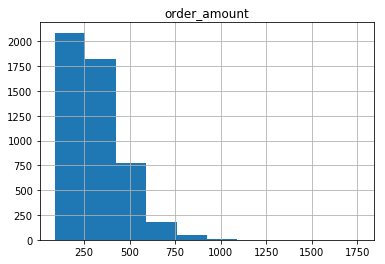

In [25]:
order_data_clean.hist(column='order_amount');

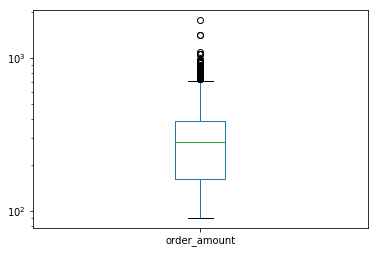

In [23]:
order_data_clean.order_amount.plot(kind='box', logy='true')

### Solutions

There are two main alternatives to getting a better AOV.
 
 1. Remove outliers, including wholesale purchases and unreasonably large per unit costs. This results in an AOV of <b>\$302</b>. This would be the best option if we are concerned about accurance and are looking to find the mean without outliers such as fraud or business purchases.
 
 
 2. Use a robust statistic such as median rather than mean. This results in an AOV of <b>\$284</b>. This method retains 93.8% accuracy (284/302), while being significantly simpler to implement. This would  involve lower computing and time cost and maintain relevance even with other types of issue compared than the alternative as it is robust to outliers unlike mean.
 
 
<i>Shop 78 and user 607 should both be investigated after this analysis for any inconsistencies with internal data.</i>

<hr>

## Question 2: SQL Problems

### How many orders were shipped by Speedy Express in total?

SELECT Shippers.ShipperName AS 'Shipper', COUNT(Orders.ShipperID) AS 'Total Orders Shipped'
FROM Orders
	INNER JOIN Shippers
		ON Orders.ShipperID = Shippers.ShipperID
WHERE Orders.ShipperID = 1;

| Shipper        	| Total Orders Shipped 	|
|----------------	|----------------------	|
| Speedy Express 	| 54                   	|

Speedy Express shipped <b>52</b> orders in total.

### What is the last name of the employee with the most orders?

SELECT Employees.LastName AS 'Employee Last Name', COUNT(Orders.OrderID) AS 'Total Orders'
FROM Employees
	INNER JOIN Orders
		ON Employees.EmployeeID = Orders.EmployeeID
GROUP BY Employees.LastName
ORDER BY COUNT(Orders.OrderID) desc limit 1;

| Employee Last Name 	| Total Orders  	|
|--------------------	|---------------	|
| Peacock            	| 40            	|

<b>Peacock</b> is the last name of the employee with the most orders.

### What product was ordered the most by customers in Germany?

SELECT Products.ProductName AS 'Product', COUNT(Products.ProductName) AS 'Number of Orders'
FROM Customers
	INNER JOIN Orders
    	ON Customers.CustomerID = Orders.CustomerID
    INNER JOIN OrderDetails
    	ON Orders.OrderID = OrderDetails.OrderID
    INNER JOIN Products
    	ON OrderDetails.ProductID = Products.ProductID
WHERE Customers.Country = 'Germany'

| Product           	| Number of Orders |
|-------------------	|------------------|
| Gorgonzola Telino 	| 5                |

<b>Gorgonzola Telina</b> was ordered the most by customers in Germany.

<hr>